In [566]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [567]:
os.getcwd()

'/Users/chance/Desktop/LH_home/ksc'

In [568]:
folder = os.listdir()

file = []
for f in folder:
    if "gajwa" in f:
        data = pd.read_csv("./" + f, encoding="cp949", skiprows=15)
        data = data[list(data.columns[:11])]
        file.append(data)
    
gajwa = pd.concat(file)
gajwa = gajwa.dropna(axis=0)
gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명
0,경상남도 진주시 가좌동,1***,25m미만,12.00,월세,201902,16,200,35,2016.0,가좌길74번길
1,경상남도 진주시 가좌동,1***,8m미만,12.00,전세,201901,5,"4,500",0,2016.0,가좌길78번길
3,경상남도 진주시 가좌동,1***,8m미만,14.20,월세,201906,25,300,32,2016.0,가좌길60번길
4,경상남도 진주시 가좌동,1***,12m미만,14.85,월세,201902,20,500,35,2019.0,가좌길64번길
5,경상남도 진주시 가좌동,1***,12m미만,14.85,월세,201908,28,500,35,2019.0,가좌길64번길
...,...,...,...,...,...,...,...,...,...,...,...
181,경상남도 진주시 가좌동,4**,12m미만,111.15,월세,201805,13,"7,000",27,2010.0,가좌안골길16번길
183,경상남도 진주시 가좌동,4**,12m미만,118.80,전세,201712,12,"4,500",0,2010.0,개양로6번길
184,경상남도 진주시 가좌동,4**,12m미만,124.26,월세,201712,28,"11,000",15,2007.0,진주대로568번길
185,경상남도 진주시 가좌동,4**,12m미만,126.52,전세,201802,11,"10,000",0,2010.0,개양로


In [569]:
gajwa.도로조건.value_counts()

12m미만    1039
8m미만      621
-         610
25m미만     120
25m이상      43
Name: 도로조건, dtype: int64

In [570]:
geo = pd.read_csv("./geocoding.csv")
gajwa["경도"] = geo.X
gajwa["위도"] = geo.Y

# gajwa = gajwa.fillna({'건축년도':gajwa['건축년도'].mode()[0]})
# gajwa = gajwa.fillna({'도로명':gajwa['도로명'].mode()[0]})
# gajwa = gajwa.fillna({'도로조건':gajwa['도로조건'].mode()[0]})

# 도로조건을 정수로 변환
road=[]
for a in gajwa["도로조건"]:
    if a=="-":
        a = "0"
    if a=="25m이상":
        a = "30"
    road.append(int(a.split("m")[0]))
gajwa["도로조건"] = road


# 년월 column 생성
year=[]
month=[]
for d in gajwa["계약년월"]:
    day = pd.to_datetime(d, format="%Y%m")
    year.append(day.year)
    month.append(day.month)

gajwa["year"] = year
gajwa["month"] = month

built_day = [pd.to_datetime(d, format="%Y").year for d in gajwa["건축년도"]]
gajwa["건축년도"] = built_day

# 위치 column만들기
gajwa["location"] = gajwa.시군구 + " " + gajwa.도로명

# 계약년월 기준으로 전월세전환율 입력하기
rate = pd.read_csv("./rate.csv", encoding="cp949")
rate = rate.T
rate = rate[3:]

month = []
for r in rate.index:
    new = "".join(r.split("."))
    month.append(int(new))

rate["계약년월"] = month
rate.columns = ["전월세전환율", "계약년월"]
rate.head()

gajwa = pd.merge(left=gajwa, right=rate, how="inner", on="계약년월")

keep = [int("".join(k.split(","))) for k in gajwa["보증금(만원)"]]
gajwa["보증금(만원)"] = keep


# 전월세전환율 기준으로 보증금+월세의 가치를 전세로 치환하여 value column으로 만들어준다.
value=[round(gajwa["월세(만원)"][i] * 12 / (gajwa["전월세전환율"][i]/100) + gajwa["보증금(만원)"][i]) for i in range(len(gajwa))]
gajwa["전세전환가격"] = value
#gajwa["도로별 전세값평균"] = gajwa.groupby("도로명").전세전환가격.transform("mean")


# 도로명 결측치 제거
indexNames = []
for i in range(len(gajwa["도로명"])):
    if "번길" not in gajwa["도로명"][i]:
        indexNames.append(i)

gajwa.drop(indexNames, inplace=True)

# covid = []
# for c in gajwa.year:
#     if c in [2020, 2021]:
#         covid.append(1)
#     else:
#         covid.append(0)
# gajwa["coivd"] = covid

gajwa["price_per_m2"] = gajwa.전세전환가격 / gajwa["계약면적(㎡)"]
gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격,price_per_m2
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,가좌길74번길,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435,702.916667
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,가좌길64번길,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735,588.215488
3,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,가좌길48번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000,187.500000
4,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,가좌길44번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000,277.777778
5,경상남도 진주시 가좌동,1***,12,18.00,전세,201902,24,5000,0,2019,가좌길36번길,128.102026,35.149158,2019,2,경상남도 진주시 가좌동 가좌길36번길,5.1,5000,277.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2422,경상남도 진주시 가좌동,1***,12,40.00,월세,201711,8,5000,10,2006,진주대로404번길,128.106121,35.158214,2017,11,경상남도 진주시 가좌동 진주대로404번길,5.0,7400,185.000000
2423,경상남도 진주시 가좌동,4**,12,50.00,월세,201711,23,7000,10,2011,진주대로568번길,128.117191,35.162341,2017,11,경상남도 진주시 가좌동 진주대로568번길,5.0,9400,188.000000
2424,경상남도 진주시 가좌동,1***,8,80.00,전세,201711,9,14000,0,2016,가좌길78번길,128.117191,35.162341,2017,11,경상남도 진주시 가좌동 가좌길78번길,5.0,14000,175.000000
2425,경상남도 진주시 가좌동,1***,12,84.69,월세,201711,13,700,60,1990,가좌길48번길,128.117191,35.162341,2017,11,경상남도 진주시 가좌동 가좌길48번길,5.0,15100,178.297320


## 지도

In [571]:
import math as m

def distance(x1, x2, y1, y2):
    radius = 6371 # 지구 반지름(km)
    toRadian = m.pi / 180

    deltaLatitude = abs(x1 - x2) * toRadian
    deltaLongitude = abs(y1 - y2) * toRadian

    sinDeltaLat = m.sin(deltaLatitude / 2)
    sinDeltaLng = m.sin(deltaLongitude / 2)
    squareRoot = m.sqrt(sinDeltaLat * sinDeltaLat + m.cos(x1 * toRadian) * m.cos(x2 * toRadian) * sinDeltaLng * sinDeltaLng)

    distance = 2 * radius * m.asin(squareRoot)

    return distance

In [572]:
gnu_lat = 35.1530444
gnu_long = 128.1010899

gnu_dist = []
for long, lat in zip(gajwa["경도"], gajwa["위도"]):
    d = distance(gnu_lat, lat, gnu_long, long)
    gnu_dist.append(d)
gajwa["gnu_distance"] = gnu_dist

# gajwa["gnu_distance_per_m2"] = gajwa.gnu_distance / gajwa["계약면적(㎡)"]

## 데이터 시각화

In [573]:
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},)

In [574]:
def remove_out(dataframe, remove_col):
    dff = dataframe
    for k in remove_col:
        level_1q = dff[k].quantile(0.25)
        level_3q = dff[k].quantile(0.7)
        IQR = level_3q - level_1q
        rev_range = 3  # 제거 범위 조절 변수
        dff = dff[(dff[k] <= level_3q + (rev_range * IQR)) & (dff[k] >= level_1q - (rev_range * IQR))]
        dff = dff.reset_index(drop=True)
    return dff

gajwa = remove_out(gajwa, ["gnu_distance"])

gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격,price_per_m2,gnu_distance
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,가좌길74번길,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435,702.916667,0.657356
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,가좌길64번길,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735,588.215488,0.734594
2,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,가좌길48번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000,187.500000,0.796668
3,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,가좌길44번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000,277.777778,0.796668
4,경상남도 진주시 가좌동,1***,12,18.00,전세,201902,24,5000,0,2019,가좌길36번길,128.102026,35.149158,2019,2,경상남도 진주시 가좌동 가좌길36번길,5.1,5000,277.777778,0.440456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,경상남도 진주시 가좌동,4**,12,25.00,전세,201711,29,4000,0,2009,개양로6번길,128.103328,35.145290,2017,11,경상남도 진주시 가좌동 개양로6번길,5.0,4000,160.000000,0.885957
1687,경상남도 진주시 가좌동,1***,8,30.00,월세,201711,26,250,30,1987,가좌길60번길,128.108839,35.155111,2017,11,경상남도 진주시 가좌동 가좌길60번길,5.0,7450,248.333333,0.741008
1688,경상남도 진주시 가좌동,1***,8,30.00,월세,201711,26,300,38,2012,가좌길29번길,128.103328,35.145290,2017,11,경상남도 진주시 가좌동 가좌길29번길,5.0,9420,314.000000,0.885957
1689,경상남도 진주시 가좌동,1***,12,40.00,월세,201711,8,5000,10,2006,진주대로404번길,128.106121,35.158214,2017,11,경상남도 진주시 가좌동 진주대로404번길,5.0,7400,185.000000,0.734594


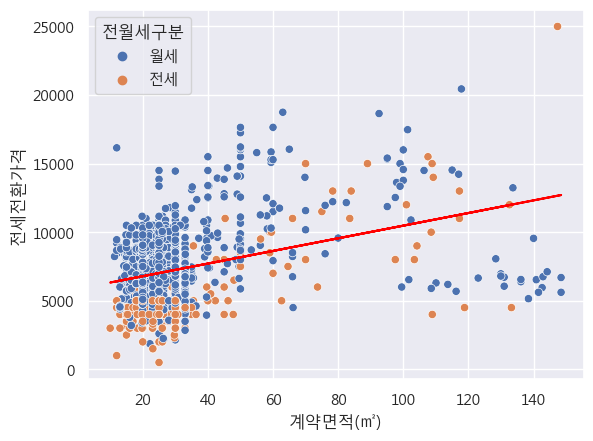

In [575]:
sns.scatterplot(data = gajwa, x = "계약면적(㎡)", y = "전세전환가격", hue = "전월세구분")
# sns.lmplot(data = gajwa, x = "계약면적(㎡)", y = "전세전환가격")
m, b = np.polyfit(gajwa["계약면적(㎡)"] , gajwa["전세전환가격"], 1)
plt.plot(gajwa["계약면적(㎡)"], m * gajwa["계약면적(㎡)"] + b, color = "red")
plt.show()

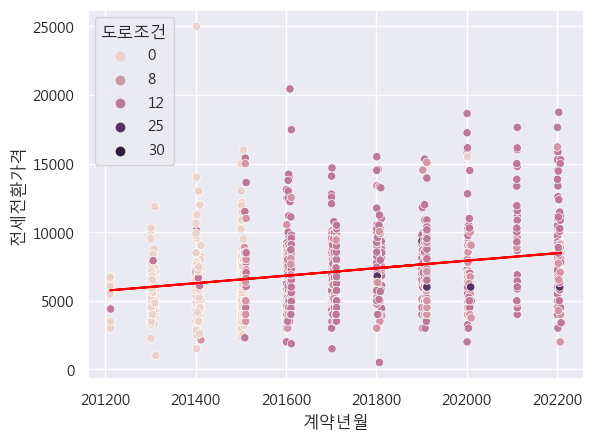

In [576]:
sns.scatterplot(data = gajwa, x = "계약년월", y = "전세전환가격", hue = "도로조건")
m, b = np.polyfit(gajwa["계약년월"] , gajwa["전세전환가격"], 1)
plt.plot(gajwa["계약년월"], m * gajwa["계약년월"] + b, color = "red")
plt.show()

In [577]:
# area = []

# for long, lat in zip(gajwa["경도"],gajwa["위도"]) :
#     if 128.102554 < long < 128.107094 and 35.155823 < lat < 35.162156 :
#         area.append('후문')
#     elif 128.107502 < long < 128.116019 and 35.155877 < lat < 35.158884 :
#         area.append('경찰서')
#     elif 128.105510 < long < 128.109887 and 35.152340 < lat <35.155835 :
#         area.append('정문')
#     elif 128.099328 < long < 128.105970 and 35.14718 < lat < 35.151686 :
#         area.append('남문')
#     elif 128.102356 < long < 128.118509 and 35.161807 < lat < 35.166844 :
#         area.append('호탄')
#     elif 128.107524 < long < 128.118378 and 35.159442 < lat < 35.161644 :
#         area.append('호탄')
#     else :
#         area.append('그 외')

# gajwa["area"] = area
# gajwa

In [578]:
# import folium

# m = folium.Map(location=[gnu_lat, gnu_long], zoom_start=14)

# for lo, la, in zip(gajwa.경도, gajwa.위도):
#     folium.Marker([la, lo]).add_to(m)

# m

In [579]:
# m = folium.Map(location=[gajwa.위도.max(),gajwa.경도.min()], zoom_start=16)
# folium.Marker([gajwa.위도.max(),gajwa.경도.min()]).add_to(m)
# m

In [580]:
# # 전세 월세 구분 데이터셋
# gajwa = gajwa[gajwa.전월세구분 == "월세"]
# gajwa = pd.DataFrame.drop(gajwa, columns=["전월세구분"], axis=1)

#원핫인코딩
gajwa = pd.get_dummies(gajwa, columns = ["전월세구분"])


gajwa

,시군구,번지,도로조건,계약면적(㎡),계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,...,위도,year,month,location,전월세전환율,전세전환가격,price_per_m2,gnu_distance,전월세구분_월세,전월세구분_전세
0,경상남도 진주시 가좌동,1***,25,12.00,201902,16,200,35,2016,가좌길74번길,...,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435,702.916667,0.657356,1,0
1,경상남도 진주시 가좌동,1***,12,14.85,201902,20,500,35,2019,가좌길64번길,...,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735,588.215488,0.734594,1,0
2,경상남도 진주시 가좌동,1***,8,16.00,201902,20,3000,0,2016,가좌길48번길,...,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000,187.500000,0.796668,0,1
3,경상남도 진주시 가좌동,1***,8,18.00,201902,20,5000,0,2016,가좌길44번길,...,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000,277.777778,0.796668,0,1
4,경상남도 진주시 가좌동,1***,12,18.00,201902,24,5000,0,2019,가좌길36번길,...,35.149158,2019,2,경상남도 진주시 가좌동 가좌길36번길,5.1,5000,277.777778,0.440456,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,경상남도 진주시 가좌동,4**,12,25.00,201711,29,4000,0,2009,개양로6번길,...,35.145290,2017,11,경상남도 진주시 가좌동 개양로6번길,5.0,4000,160.000000,0.885957,0,1
1687,경상남도 진주시 가좌동,1***,8,30.00,201711,26,250,30,1987,가좌길60번길,...,35.155111,2017,11,경상남도 진주시 가좌동 가좌길60번길,5.0,7450,248.333333,0.741008,1,0
1688,경상남도 진주시 가좌동,1***,8,30.00,201711,26,300,38,2012,가좌길29번길,...,35.145290,2017,11,경상남도 진주시 가좌동 가좌길29번길,5.0,9420,314.000000,0.885957,1,0
1689,경상남도 진주시 가좌동,1***,12,40.00,201711,8,5000,10,2006,진주대로404번길,...,35.158214,2017,11,경상남도 진주시 가좌동 진주대로404번길,5.0,7400,185.000000,0.734594,1,0


In [581]:
gajwa_data = pd.DataFrame.drop(gajwa, columns=["시군구","계약년월", "번지", "도로명", "계약일", "보증금(만원)", "월세(만원)", "location", "경도", "위도", "gnu_distance", "전월세전환율"], axis=1)

#gajwa_data.distance = gajwa_data.distance.transform(lambda x: (x - x.mean()) / x.std())
#gajwa_data.전세전환가격 = gajwa_data.전세전환가격.transform(lambda x: (x - x.mean()) / x.std())
gajwa_data

,도로조건,계약면적(㎡),건축년도,year,month,전세전환가격,price_per_m2,전월세구분_월세,전월세구분_전세
0,25,12.00,2016,2019,2,8435,702.916667,1,0
1,12,14.85,2019,2019,2,8735,588.215488,1,0
2,8,16.00,2016,2019,2,3000,187.500000,0,1
3,8,18.00,2016,2019,2,5000,277.777778,0,1
4,12,18.00,2019,2019,2,5000,277.777778,0,1
...,...,...,...,...,...,...,...,...,...
1686,12,25.00,2009,2017,11,4000,160.000000,0,1
1687,8,30.00,1987,2017,11,7450,248.333333,1,0
1688,8,30.00,2012,2017,11,9420,314.000000,1,0
1689,12,40.00,2006,2017,11,7400,185.000000,1,0


# 머신러닝

In [582]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import plot_importance
import catboost
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [583]:
from sklearn.model_selection import train_test_split

# X = gajwa_data.drop(["전세전환가격"], axis=1)
# y = gajwa_data['전세전환가격']

gajwa_data = gajwa_data.drop(["전세전환가격"], axis=1)
X = gajwa_data.drop(["price_per_m2"], axis=1)
y = gajwa_data['price_per_m2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1645)

X_train

# scaler = StandardScaler()
# X_train_standardized = scaler.fit_transform(X_train)
# X_test_standardized = scaler.fit_transform(X_test)

# minmaxScaler = MinMaxScaler()
# X_train_standardized2 = minmaxScaler.fit_transform(X_train)
# X_test_standardized2 = minmaxScaler.fit_transform(X_test)

,도로조건,계약면적(㎡),건축년도,year,month,전월세구분_월세,전월세구분_전세
817,8,21.00,2011,2017,1,0,1
551,12,25.00,2010,2016,8,0,1
520,12,99.51,2006,2015,10,1,0
14,12,25.00,2010,2019,2,1,0
32,8,26.00,2016,2019,2,0,1
...,...,...,...,...,...,...,...
836,8,39.66,2002,2017,1,1,0
1115,8,20.00,2018,2022,2,0,1
26,12,25.00,2009,2019,2,0,1
77,12,20.00,2014,2019,8,0,1


## 선형회귀분석

In [584]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_preds = lr.predict(X_test)

# mse = mean_squared_error(y_test, y_preds)
# rmse = np.sqrt(mse)

# print(f"MSE : {mse:.3f}", f"RMSE: {rmse:.3f}")
# print(f"variance score : {r2_score(y_test, y_preds):.3f}")

In [585]:
# lr.fit(X_train_standardized, y_train)
# lr.score(X_test_standardized, y_test)

## Ridge

In [600]:
R_model = Ridge()
R_model.fit(X_train, y_train)
y_pred = R_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2
# print(R_model.score(X_test, y_test))

# R_model.fit(X_train_standardized, y_train)
# R_model.score(X_test_standardized, y_test)

0.5688742196198084

## Lasso

In [601]:
L_model = Lasso(alpha=0.5)
L_model.fit(X_train, y_train)
y_pred = L_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

# L_model.fit(X_train_standardized, y_train)
# L_model.score(X_test_standardized, y_test)

0.5685441976086043

## ElasticNet

In [602]:
ela = ElasticNet(alpha=0.5)
ela.fit(X_train, y_train)
y_pred = ela.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2
# print(ela.score(X_test, y_test))

# ela.fit(X_train_standardized, y_train)
# ela.score(X_test_standardized, y_test)

0.523213913943426

## 랜덤포레스트

In [606]:
randomforest = RandomForestRegressor(random_state=0, n_jobs=-1)
randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.790544773959112

In [605]:
gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

# gbm.fit(X_train_standardized, y_train)
# print(gbm.score(X_test_standardized, y_test))

0.8048427004516161

## LightGBM

In [607]:
lightgbm = lgb.LGBMRegressor()
lightgbm.fit(X_train, y_train)
y_pred = lightgbm.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

# lightgbm.fit(X_train_standardized, y_train)
# print(lightgbm.score(X_test_standardized, y_test))

0.8031730228149417

## XGBoost

In [608]:
xgboost = XGBRegressor()
xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

# xgboost.fit(X_train_standardized, y_train)
# xgboost.score(X_test_standardized, y_test)

/Users/chance/opt/anaconda3/envs/py3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



0.7647560504540074

## CatBoost

In [609]:
cb = catboost.CatBoostRegressor()
cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

Learning rate set to 0.042941
0:	learn: 112.8057613	total: 3.44ms	remaining: 3.44s
1:	learn: 109.9638262	total: 3.94ms	remaining: 1.97s
2:	learn: 107.4359932	total: 4.38ms	remaining: 1.46s
3:	learn: 104.8836030	total: 4.81ms	remaining: 1.2s
4:	learn: 102.4915004	total: 5.24ms	remaining: 1.04s
5:	learn: 100.0575277	total: 5.6ms	remaining: 928ms
6:	learn: 98.0014445	total: 5.96ms	remaining: 845ms
7:	learn: 96.0389020	total: 6.31ms	remaining: 782ms
8:	learn: 94.2389598	total: 6.64ms	remaining: 731ms
9:	learn: 92.3543724	total: 7ms	remaining: 693ms
10:	learn: 90.5769817	total: 7.36ms	remaining: 661ms
11:	learn: 89.0376310	total: 8.29ms	remaining: 683ms
12:	learn: 87.6076647	total: 8.64ms	remaining: 656ms
13:	learn: 85.9513980	total: 9.13ms	remaining: 643ms
14:	learn: 84.4551940	total: 9.6ms	remaining: 630ms
15:	learn: 83.0369844	total: 10.1ms	remaining: 620ms
16:	learn: 81.6726227	total: 10.5ms	remaining: 608ms
17:	learn: 80.3358640	total: 10.9ms	remaining: 595ms
18:	learn: 79.2348108	tota

0.7994656088232004

## HyperParameter

In [594]:
import optuna
from optuna.samplers import TPESampler

# random sampler
sampler = TPESampler(seed=10)

# define function
def objective(trial):

    param = {
        'objective': 'regression',
        'verbose': -1,
        'metric': 'rmse', 
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    # Generate model
    lgbm = lgb.LGBMRegressor(**param)
    lgbm = lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], 
                           verbose=0, early_stopping_rounds=25)

    # xgboost = XGBRegressor(**param)
    # xgboost.fit(X_train, y_train, eval_set=[(X_test, y_test)], 
    #                        verbose=0, early_stopping_rounds=25)


    # * 평기 지표이다.
    # 원하는 평가 지표에 따라 사용하면 된다.                         
    # MSE = mean_squared_error(y_test, lgbm.predict(X_test))
    # return MSE
    # rmse = mean_squared_error(y_test, lgbm.predict(X_test), squared=False)
    rmse = mean_squared_error(y_test, lgbm.predict(X_test), squared=False)
    return rmse

    # r2 = r2_score(y_test, lgbm.predict(X_test)
    # return r2

study = optuna.create_study(direction='minimize', sampler=sampler)

# * n_trials의 경우 optuna를 몇번 실행하여 hyper parameter를 찾을 것인지를 정한다.
# 50으로 설정해도 유의미한 값이 나온다.
study.optimize(objective, n_trials=100)

[I 2022-12-05 02:06:22,594] A new study created in memory with name: no-name-78f5f40c-f832-453f-af46-d700722211d8
/var/folders/zs/nhxg8dr522z1hvsl9b42pyd40000gn/T/ipykernel_21573/4179727320.py:15: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/zs/nhxg8dr522z1hvsl9b42pyd40000gn/T/ipykernel_21573/4179727320.py:16: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/var/folders/zs/nhxg8dr522z1hvsl9b42pyd40000gn/T/ipykernel_21573/4179727320.py:17: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_flo

In [595]:
optuna.visualization.plot_param_importances(study)

In [596]:
trial = study.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 51.19772354034532,
params {'num_leaves': 17, 'colsample_bytree': 0.9818632165046602, 'reg_alpha': 0.9504774976734625, 'reg_lambda': 0.026111984951025513, 'max_depth': 9, 'learning_rate': 0.005387804181200352, 'n_estimators': 1065, 'min_child_samples': 9, 'subsample': 0.5900490382283101}


In [597]:
final_model = lgb.LGBMRegressor(**trial_params)
# final_model = XGBRegressor(**trial_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.8068294265157188

최종점수 : 0.8091969246246243

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

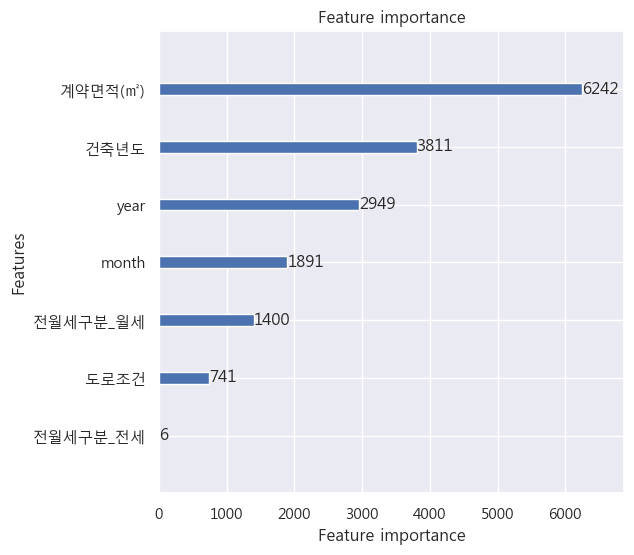

In [611]:
fig, ax = plt.subplots(figsize =(6,6))
plot_importance(final_model, ax=ax)

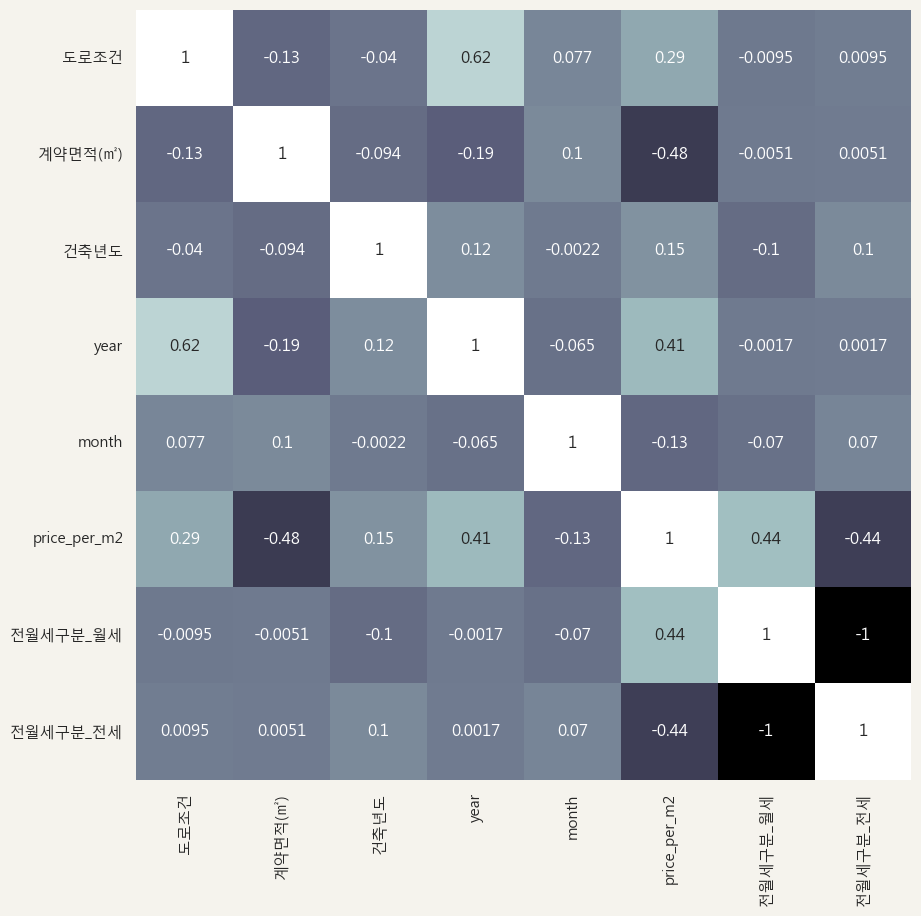

In [610]:
corr = gajwa_data.corr()
plt.figure(figsize = (10, 10), facecolor = "#F5F3ED")
sns.heatmap(corr, annot = True, cbar = False,cmap = "bone")
plt.show()

In [612]:
X_test

,도로조건,계약면적(㎡),건축년도,year,month,전월세구분_월세,전월세구분_전세
2,8,16.0,2016,2019,2,0,1
860,8,33.0,2013,2016,12,1,0
1413,0,25.0,2012,2013,8,1,0
381,0,25.0,2007,2015,1,1,0
264,12,28.0,2006,2020,3,1,0
...,...,...,...,...,...,...,...
1561,0,33.0,2007,2012,11,1,0
604,12,16.0,2016,2016,2,1,0
1668,12,35.0,2011,2018,1,1,0
144,8,20.0,2015,2020,1,0,1


In [625]:
y = X_test.columns
x = [8, 28, 1977, 2022, 12, 1, 0]

x = pd.DataFrame(x, y)
x = x.T

In [650]:
y

Index(['도로조건', '계약면적(㎡)', '건축년도', 'year', 'month', '전월세구분_월세', '전월세구분_전세'], dtype='object')

In [627]:
final_model.predict(x) * 28

array([8128.62848972])

In [628]:
final_model

LGBMRegressor(colsample_bytree=0.9818632165046602,
              learning_rate=0.005387804181200352, max_depth=9,
              min_child_samples=9, n_estimators=1065, num_leaves=17,
              reg_alpha=0.9504774976734625, reg_lambda=0.026111984951025513,
              subsample=0.5900490382283101)

In [632]:
final_model.booster_.save_model('./lh_home.txt')

In [633]:
load_model = lgb.Booster(model_file='./lh_home.txt')
load_model.predict(x) * 28

array([8128.62848972])

In [661]:
import pandas as pd

def predict():
    load_model = lgb.Booster(model_file='./lh_home.txt')

    road = int(input("도로조건을 입력하세요 : "))
    m2 = int(input("거주면적을 입력하세요 : "))
    built = int(input("건축년도를 입력하세요 : "))
    year = int(input("계약년도를 입력하세요 : "))
    month = int(input("계약월을 입력하세요 : "))
    deposit = int(input("보증금을 입력하세요 : (만원)"))
    rate = 6
    
    x = [road, m2, built, year, month, 1, 0]

    y = [['도로조건', '계약면적(㎡)', '건축년도', 'year', 'month', '전월세구분_월세', '전월세구분_전세']]
    data = pd.DataFrame(x, y)
    data = data.T

    load_model = lgb.Booster(model_file='./lh_home.txt')
    price = load_model.predict(data) * m2
    pred = (price - deposit) * rate / 1200
    return pred

In [662]:
print(predict())

array([39.14314245])